In [29]:
import sys
sys.path.append('../../')

matplotlib settings set


In [30]:
from scripts.utils import data_path, set_mpl, read_hamelin, add_datetime_features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


%matplotlib inline

set_mpl()

matplotlib settings set


# Data reading and preprocessing 

In [31]:
energy, weather, metadata, twitter, trends = read_hamelin()


    Loading Hamelin data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Houses number removed: 6, 17, 24, 25. 
    Houses with PV: ['13', '15', '26', '33'] 
    HOUSEHOLD and HEATPUMP energy consumption are separated. 
    Resolution: 60min 

    May-June 2019 data for home #34 excluded 
    Data before 2018-05-18 excluded (gaps)
    Data with zero difference between consecutive values dropped (malfunction)

    reutrns:
    df_energy: pd.DataFrame with energy consumption data
    df_weather: pd.DataFrame with weather data
    df_metadata: pd.DataFrame with metadata

    


In [32]:
heat_cols = [col for col in energy.columns if 'P_HEAT' in col]
home_cols = [col for col in energy.columns if 'P_HOME' in col]
tot_cols = [col for col in energy.columns if 'P_TOT' in col]

energy['homes_num'] = energy[tot_cols].count(axis=1)
energy['P_HEAT_avg'] = energy[heat_cols].sum(axis=1)/energy['homes_num']
energy['P_HOME_avg'] = energy[home_cols].sum(axis=1)/energy['homes_num']
energy['P_TOT_avg'] = energy[tot_cols].sum(axis=1)/energy['homes_num']


energy, weather = add_datetime_features([energy, weather])



## Missing data

<AxesSubplot: title={'left': 'Proportion of missing values in total energy consumption'}>

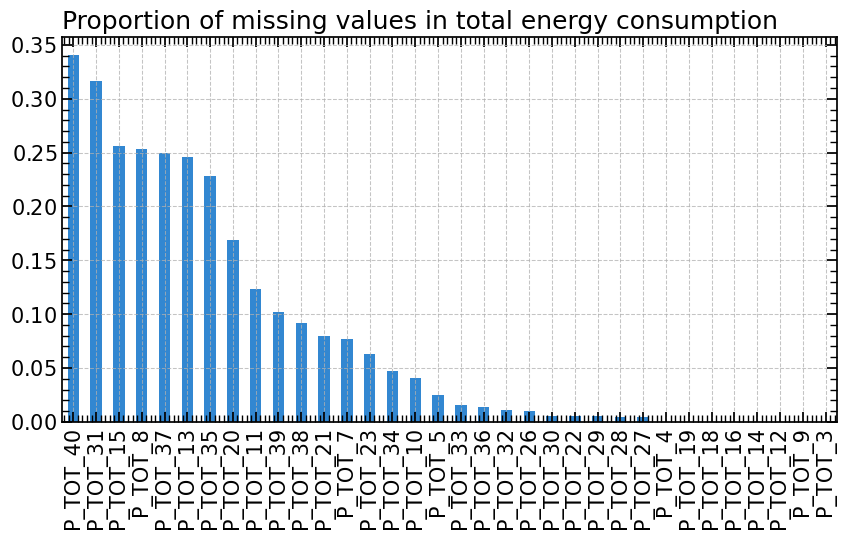

In [33]:
energy[tot_cols].isna().mean(axis=0).sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title='Proportion of missing values in total energy consumption')


# examples of data

## individual home data (home 3)

Text(0.0, 1.0, 'Home 3')

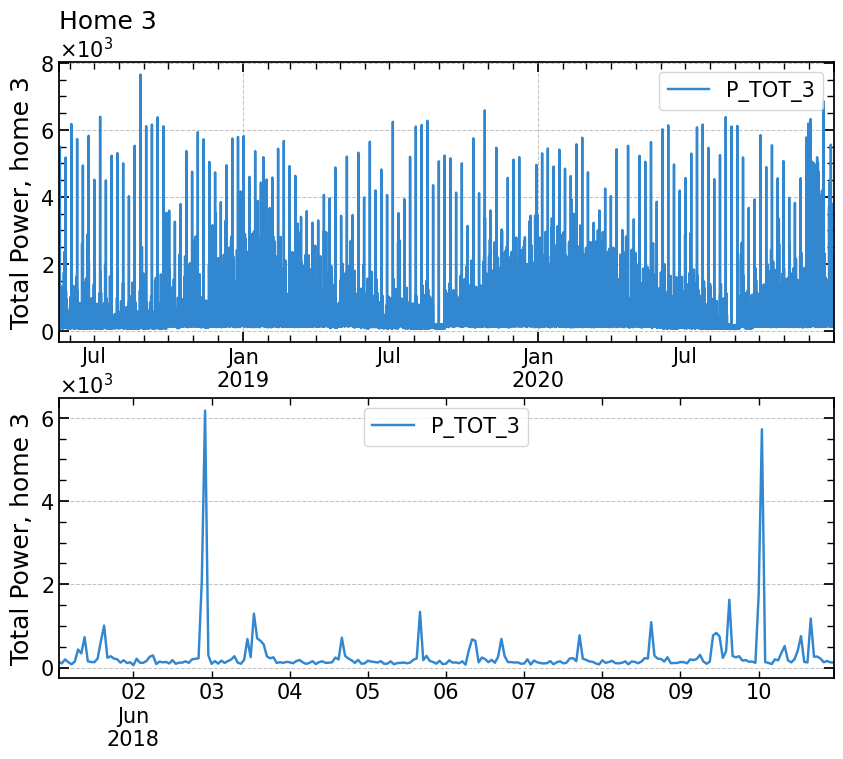

In [34]:
fig,  [ax1, ax2] =  plt.subplots(2, figsize = (10,8))

energy[['P_TOT_3']].plot(ax = ax1, ylabel = 'Total Power, home 3')
energy.query('index > "2018-06-01" & index < "2018-06-11"')[['P_TOT_3']].plot(ax = ax2, ylabel = 'Total Power, home 3')
ax1.set_title('Home 3')

## December 2020 average home data and weather

<AxesSubplot: xlabel='WEATHER_T', ylabel='P_HEAT_avg'>

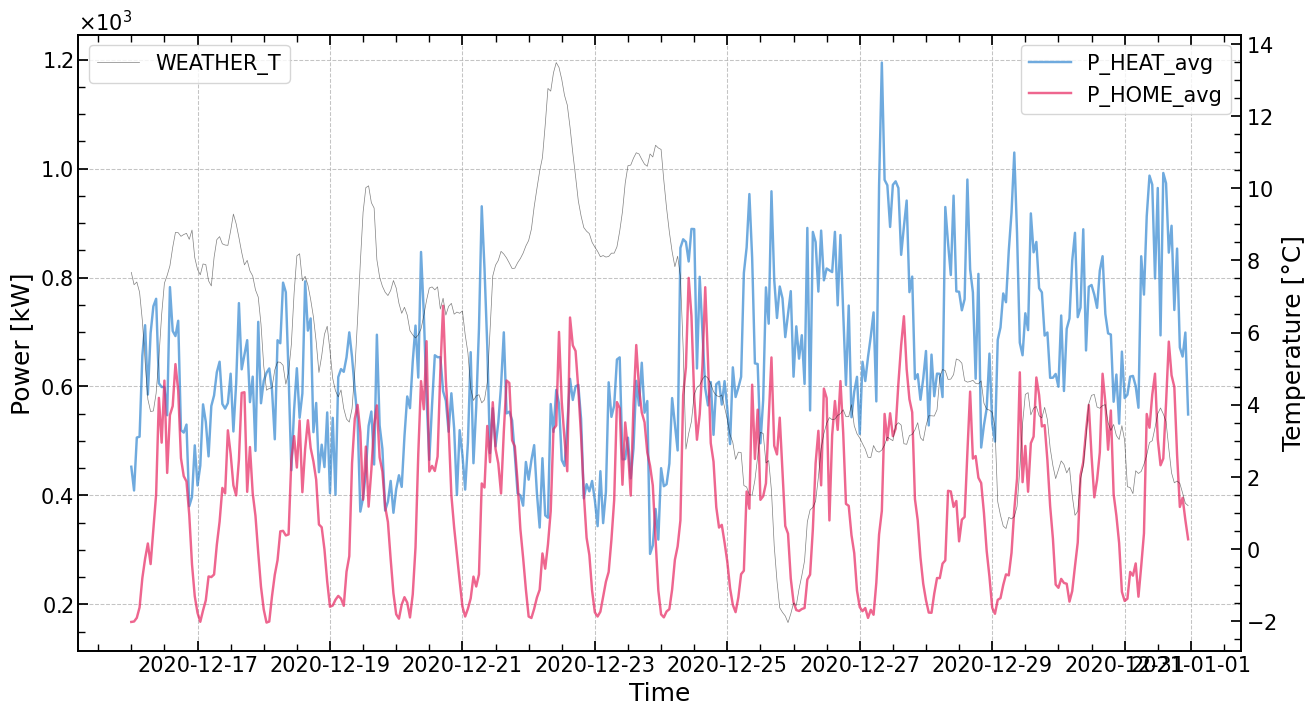

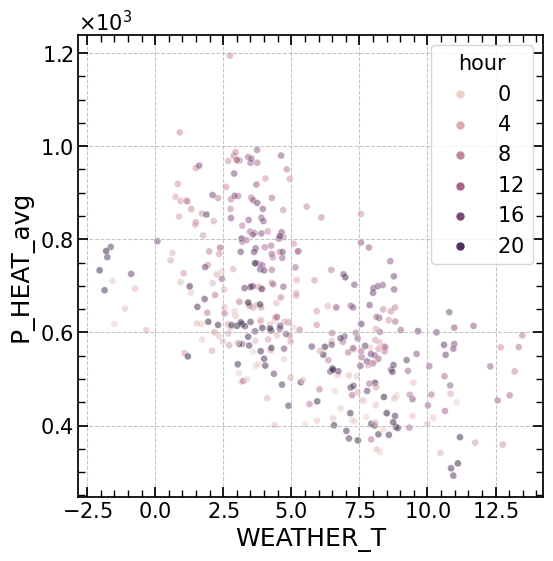

In [36]:
fig,  ax =  plt.subplots( figsize = (15,8))
ax2 = ax.twinx()
ax2.grid(False)
query = 'year == 2020 and month in [12] and doy>350'
subset = energy.query(query)
subset_weather = weather.query(query)
#ax.plot(subset.index, subset['P_substation'], label='P_substation')
ax.plot(subset.index, subset['P_HEAT_avg'], label='P_HEAT_avg', alpha = 0.7)
ax.plot(subset.index, subset['P_HOME_avg'], label='P_HOME_avg', alpha = 0.7)
ax2.plot(subset_weather.index, subset_weather['WEATHER_T'], label='WEATHER_T', color='k', lw = 0.5, alpha=0.5)


ax.legend(loc = 'upper right')
ax2.legend(loc = 'upper left')

ax.set_xlabel('Time')
ax.set_ylabel('Power [kW]')
ax2.set_ylabel('Temperature [°C]')


fig,  ax_t =  plt.subplots( figsize = (6,6))

sns.scatterplot(x=subset_weather['WEATHER_T'], y=subset['P_HEAT_avg'], hue = subset['hour'], alpha=0.5, ax = ax_t)



# Load curves

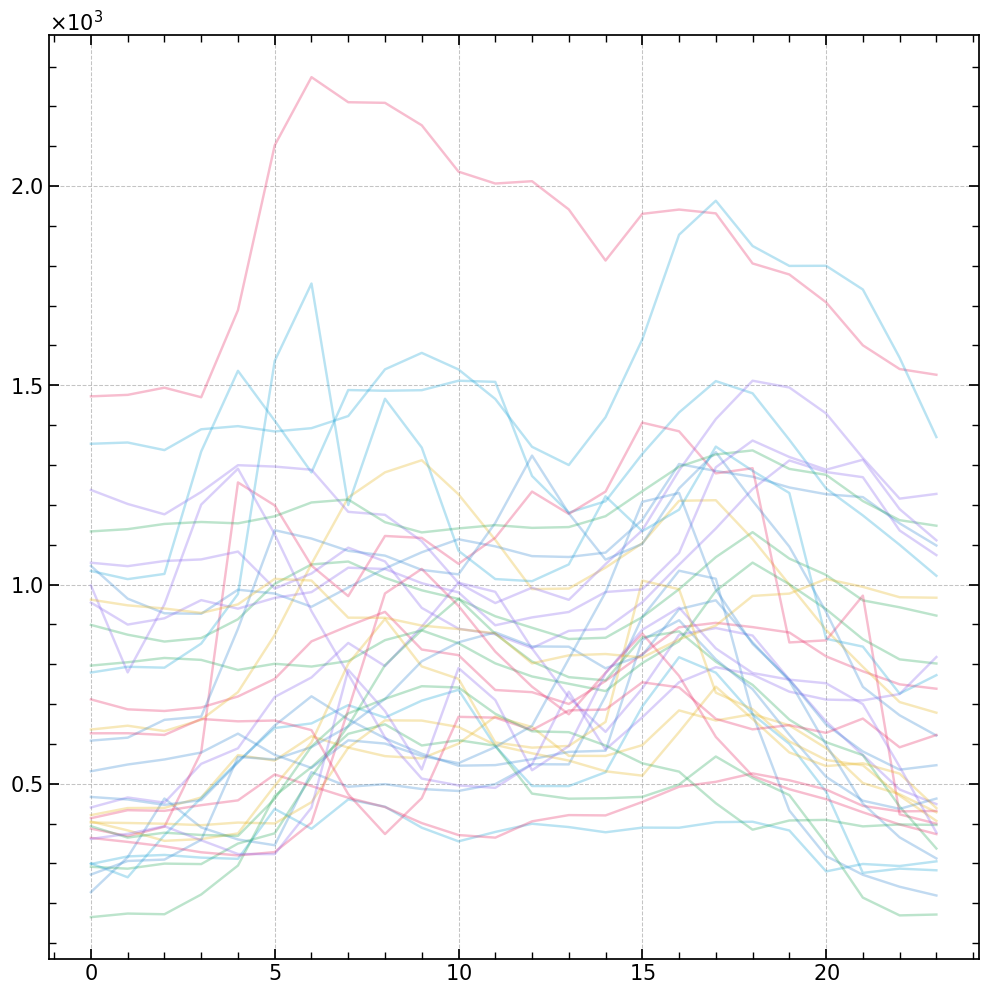

In [62]:
agg = energy.groupby(['hour'])[tot_cols].agg('mean')

fig,  ax =  plt.subplots( figsize = (12,12))

for col in tot_cols:
    ax.plot(agg.index, agg[col], label=col, alpha = 0.3)

## load curves clustering

## getting the number of clusters

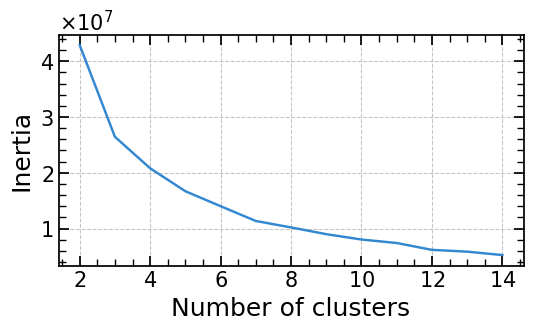

In [109]:
from sklearn.cluster import KMeans

grp = energy.groupby(['hour'])[tot_cols].agg('mean').T


inertia = []
clusters = []
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(grp)
    inertia.append(kmeans.inertia_)
    clusters.append(kmeans.labels_)

fig,  ax =  plt.subplots( figsize = (6,3))
ax.plot(range(2, 15), inertia)

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')


num_clusters = 3

## plot clusters

/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0    19
1    13
2     2
Name: cluster, dtype: int64

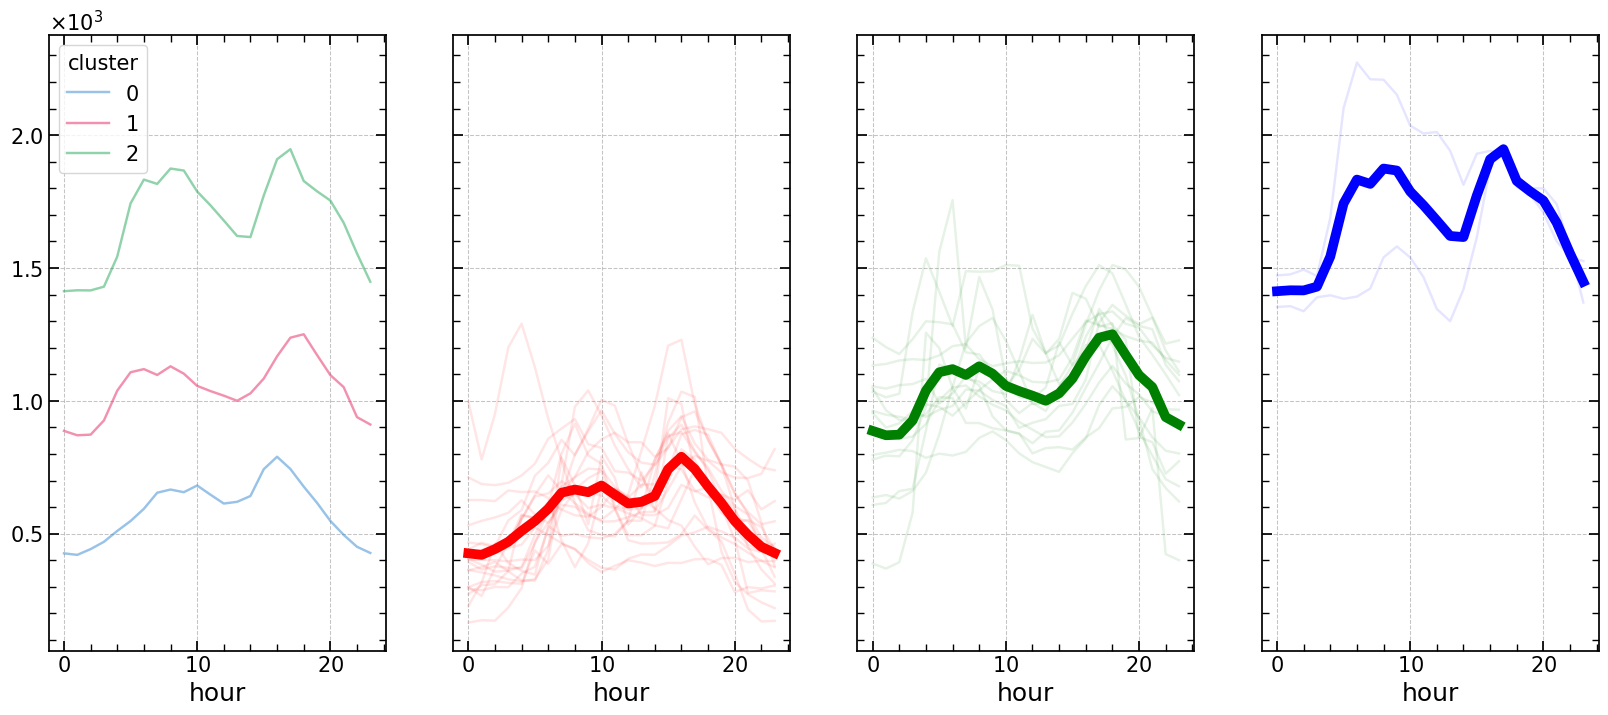

In [113]:
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(grp)
clusters_fin = kmeans.labels_

id_to_cluster = dict(zip(grp.index, clusters_fin))
cluster_to_id = {i:[] for i in range(num_clusters)}
for k, v in id_to_cluster.items():
    cluster_to_id[v].append(k)

grp['cluster'] = clusters_fin
display(grp['cluster'].value_counts().sort_index())


fig,  axs =  plt.subplots(1, num_clusters+1,  figsize = (20,8), sharey = True)

grp.groupby('cluster').mean().T.plot(ax = axs[0], alpha = 0.5)

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']


for i in range(num_clusters):
    grp[grp['cluster'] == i].drop('cluster', axis = 1).mean().plot(ax = axs[i+1], color = colors[i], alpha = 1, lw = 7,  label = 'cluster {}'.format(i))

    grp_clu = grp[grp['cluster'] == i]
    if len(grp_clu) < 100:
        grp_clu = grp_clu
    else:
        grp_clu = grp_clu.sample(100)
    
    grp_clu = grp_clu.drop('cluster', axis = 1).T
    grp_clu.plot(ax = axs[i+1], color = colors[i], alpha = 0.1, legend = False)